In [5]:
import tempfile
from functools import partialmethod


from simtk import unit  # Unit handling for OpenMM
from openmm import *
from openmm import app
from openmm.app import *
from openmm.app import PDBFile


from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

import parmed
from rdkit import Chem
import pickle
import shutil
import os
import numpy as np


from utils import approximate_volume_by_density

##############################################################


class BaseParameteriser():
    """

    .. warning :: The base class should not be used directly
    """
    na_ion_pmd = None
    cl_ion_pmd = None
    system_pmd = None


    @classmethod
    def via_rdkit(cls):
        """
        Abstract method
        """
        raise NotImplementedError

    @classmethod
    def pmd_generator(cls):
        """
        Abstract method
        """
        raise NotImplementedError

    @classmethod
    def _rdkit_setter(cls, smiles, seed = 0xf00d,**kwargs):
        """
        Prepares an rdkit molecule with 3D coordinates.

        Parameters
        ------------
        smiles : str
            SMILES string of the solute moleulce

        Returns
        ---------
        mol : rdkit.Chem.Mol
        """
        from rdkit.Chem import AllChem
        from rdkit.Chem import rdmolops


        seed = 0xf00d
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=seed)
        rdmolops.AssignStereochemistryFrom3D(mol)
        used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        mol.SetProp("_Name", used_smiles)
        mol.UpdatePropertyCache(strict=False)

        # print(Chem.MolToMolBlock(mol),file=open(f'{hash_code}_{seed}.mol','w+')) #TODO save when you know how to name it


        return mol



    @classmethod
    def _get_forcefield(cls, **kwargs):
        if "ff_path" in kwargs:
            try:
                return ForceField(kwargs['ff_path'], allow_cosmetic_attributes=True)
            except Exception as e:
                print("Specified forcefield cannot be found. Fallback to default forcefield: OpenFF 2.1.0 force field release (Sage)")
        return ForceField("openff_unconstrained-2.1.0.offxml")

    @classmethod
    def _rdkit_parameteriser(cls, mol, **kwargs):
        # from openforcefield.utils.toolkits import RDKitToolkitWrapper, ToolkitRegistry
        """
        Creates a parameterised system from rdkit molecule

        Parameters
        ----------
        mol : rdkit.Chem.Mol
        """
        try:
            molecule = Molecule.from_rdkit(mol, allow_undefined_stereo=cls.allow_undefined_stereo)
            from openff.toolkit.utils import AmberToolsToolkitWrapper
            molecule.assign_partial_charges(toolkit_registry=AmberToolsToolkitWrapper(),partial_charge_method="am1bcc")

        except Exception as e:
            raise ValueError("Charging Failed : {}".format(e))  # TODO

        return cls._off_handler(molecule, **kwargs)

    @classmethod
    def _off_handler(cls, molecule, **kwargs):
        forcefield = cls._get_forcefield(**kwargs)
        topology = Topology.from_molecules(molecule)
        openmm_system = forcefield.create_openmm_system(topology, charge_from_molecules=[molecule])

     
        tmp_dir = tempfile.mkdtemp()
        # We need all molecules as both pdb files (as packmol input)
        # and mdtraj.Trajectory for restoring bonds later.
        pdb_filename = tempfile.mktemp(suffix=".pdb", dir=tmp_dir)




        molecule.to_file(pdb_filename, "pdb")
        omm_top = PDBFile(pdb_filename).topology
        ligand_pmd = parmed.openmm.topsystem.load_topology(omm_top, openmm_system, molecule._conformers[0])

        return pdb_filename, ligand_pmd


    @classmethod
    def save(cls, file_name, file_path="./", **kwargs):
        """
        Save to file the parameterised system.

        Parameters
        ------------
        file_name : str
            No file type postfix is necessary
        file_path : str
            Default to current directory

        Returns
        --------
        path : str
            The absolute path where the trajectory is written to.
        """
        path = '{}/{}.pickle'.format(file_path, file_name)
        pickle_out = open(path, "wb")
        pickle.dump(cls.system_pmd, pickle_out)
        pickle_out.close()

        return os.path.abspath(path)




class SolutionParameteriser(BaseParameteriser):
    """
    Parameterisation of solution box, i.e. one copy of solute molecule surronded by water.

    Parameters
    --------------
    solvent_pmd : parmed.structure
        Parameterised tip3p water as parmed object
    """

    solvent_pmd = None


    @classmethod
    def run(cls, smiles=None, mol=None,seed = 0xf00d,*, solvent_smiles=None, allow_undefined_stereo=False, num_solvent=100, density=None, default_padding=1.25*unit.nanometer, box_scaleup_factor=1.5, **kwargs):
        """
        Parameterisation perfromed via rdkit.

        Parameters
        --------------------
        smiles : str
            SMILES string of the solute molecule
        solvent_smiles : str
            SMILES string of the solvent molecule, default is None, only relevant if the solute is not water.
        allow_undefined_stereo : bool
            Flag passed to OpenForceField `Molecule` object during parameterisation. When set to False an error is returned if SMILES have no/ambiguous steroechemistry. Default to False here as a sanity check for user.
        num_solvent : int
            The number of solvent molecules added into the system, only relevant if the solvent is not water. The default value is 100, but it is left for the user to determine the number of solvent molecule really needed to surrond the solute and create a big enough system.
        density : simtk.unit.quantity.Quantity
            Density of the solvent, default is None, only relevant if the solvent is not water
        default_padding : simtk.unit
            Dictates amount of water surronding the solute. Default is 1.25 nanometers, only relevant if water is the solvent.
        box_scaleup_factor : float
            Dicatates the packed volume with respect to the volume estimated from density. Default is 1.5, only relevant if the solvent is not water


        Returns
        ------------------
        system_pmd : parmed.structure
            The parameterised system as parmed object
        """
        # TODO currently only supports one solute molecule
        # sanity checks

        if smiles is None and mol is None:
            raise ValueError("smiles or mol must be provided")
        if smiles is not None and mol is not None:
            raise ValueError("smiles and mol cannot be both provided")
            
        cls.allow_undefined_stereo = allow_undefined_stereo
        cls.default_padding = default_padding.value_in_unit(unit.nanometer)
        cls.solvent_smiles = solvent_smiles
        cls.box_scaleup_factor = box_scaleup_factor
        if solvent_smiles is not None and density is None:
            raise ValueError("Density missing for the solvent {}".format(solvent_smiles))
        if density is not None:
            if type(density) is not unit.quantity.Quantity:
                raise ValueError("density needs to have unit")
            if solvent_smiles is None:
                raise ValueError("Solvent SMILES missing.")


        if mol is None and smiles is not None:
            mol = cls._rdkit_setter(smiles,seed, **kwargs)
        if mol is not None and smiles is None:
            smiles = Chem.MolToSmiles(mol)
        cls.smiles = smiles

        # mol = cls._rdkit_charger(mol)
        cls.pdb_filename, cls.ligand_pmd = cls._rdkit_parameteriser(mol, **kwargs)
        if solvent_smiles:
            mol = cls._rdkit_setter(solvent_smiles,seed, **kwargs)
            cls.solvent_pdb_filename, cls.solvent_pmd = cls._rdkit_parameteriser(mol, **kwargs)


        if cls.solvent_pmd is None:
            try:
                cls.solvent_pmd = parmed.load_file("../data/tip3p.prmtop") #TODO get this path instead of giving absolute path


            except ValueError:
                raise ValueError("Water file cannot be located")
        if solvent_smiles is None:
            cls._via_helper_water(**kwargs)
        else:
            cls._via_helper_other_solvent(density, num_solvent, **kwargs)

        return cls._add_counter_charges(**kwargs)

    @classmethod
    def _via_helper_other_solvent(cls, density, num_solvent, **kwargs):
        from openmoltools import packmol
        density = density.value_in_unit(unit.gram / unit.milliliter)

        
        box_size = approximate_volume_by_density([cls.smiles, cls.solvent_smiles], [
                                                     1, num_solvent], density=density, 		box_scaleup_factor=cls.box_scaleup_factor, box_buffer=cls.default_padding)

        packmol_out = packmol.pack_box([cls.pdb_filename, cls.solvent_pdb_filename],
                                       [1, num_solvent], box_size=box_size)

        cls.system_pmd = cls.ligand_pmd + (cls.solvent_pmd * num_solvent)
        cls.system_pmd.positions = packmol_out.openmm_positions(0)
        cls.system_pmd.box_vectors = packmol_out.openmm_boxes(0)
        try:
            # TODO should maybe delete the higher parent level? i.e. -2?
            shutil.rmtree("/".join(cls.pdb_filename.split("/")[:-1]))
            shutil.rmtree("/".join(cls.solvent_pdb_filename.split("/")[:-1]))
            del cls.ligand_pmd, cls.solvent_pmd
        except Exception as e:
            print("Error due to : {}".format(e))

        cls.system_pmd.title = cls.smiles
        return cls.system_pmd

    @classmethod
    def _via_helper_water(cls, **kwargs):
        """
        Helper function for via_rdkit

        Returns
        ------------------
        system_pmd : parmed.structure
            The parameterised system as parmed object
        """
        from pdbfixer import PDBFixer  # for solvating

        fixer = PDBFixer(cls.pdb_filename)
        if "padding" not in kwargs:
            fixer.addSolvent(padding=cls.default_padding)
        else:
            fixer.addSolvent(padding=float(kwargs["padding"]))

        tmp_dir = tempfile.mkdtemp()
        cls.pdb_filename = tempfile.mktemp(suffix=".pdb", dir=tmp_dir)
        with open(cls.pdb_filename, "w") as f:
            PDBFile.writeFile(fixer.topology, fixer.positions, f)
        complex = parmed.load_file(cls.pdb_filename)

        solvent = complex["(:HOH)"]
        num_solvent = len(solvent.residues)

        solvent_pmd = cls.solvent_pmd * num_solvent
        solvent_pmd.positions = solvent.positions

        cls.system_pmd = cls.ligand_pmd + solvent_pmd
        cls.system_pmd.box_vectors = complex.box_vectors

        try:
            shutil.rmtree("/".join(cls.pdb_filename.split("/")[:-1]))
            del cls.ligand_pmd
        except:
            pass

        cls.system_pmd.title = cls.smiles
        return cls.system_pmd

    @classmethod
    def _add_counter_charges(cls, **kwargs):
        """in case the solute molecule has a net charge, 
        counter charge are added to the system in the form of ions,
        Na+ or Cl-, in order to keep charge neutrality.
        """

        solute_charge = int(Chem.GetFormalCharge(Chem.MolFromSmiles(cls.smiles)))
        if solute_charge == 0:
            return cls.system_pmd

        if solute_charge > 0:  # add -ve charge
            if cls.cl_ion_pmd is None:
                cls.cl_ion_pmd = parmed.load_file("../mdfptools/data/cl.prmtop")
            ion_pmd = cls.cl_ion_pmd * solute_charge

        elif solute_charge < 0:  # add +ve charge
            if cls.na_ion_pmd is None:
                cls.na_ion_pmd = parmed.load_file("../mdfptools/data/na.prmtop")
            ion_pmd = cls.na_ion_pmd * abs(solute_charge)

        # replace the last few solvent molecules and replace them by the ions
        ion_pmd.coordinates = np.array([np.mean(cls.system_pmd[":{}".format(
            len(cls.system_pmd.residues) - i)].coordinates, axis=0) for i in range(abs(solute_charge))])
        cls.system_pmd = cls.system_pmd[":1-{}".format(len(cls.system_pmd.residues) - abs(solute_charge))]
        cls.system_pmd += ion_pmd

        return cls.system_pmd

    via_rdkit = partialmethod(run)



class LiquidParameteriser(BaseParameteriser):
    """
    Parameterisation of liquid box, i.e. multiple replicates of the same molecule
    """

    @classmethod  # TODO boxsize packing scale factor should be customary
    def run(cls, smiles, density, *, allow_undefined_stereo=False, num_lig=100, box_scaleup_factor=1.5,**kwargs):
        """
        Parameterisation perfromed either with openeye or rdkit toolkit.

        Parameters
        ----------------
        smiles : str
            SMILES string of the molecule to be parametersied
        density : simtk.unit
            Density of liquid box
        allow_undefined_stereo : bool
            Flag passed to OpenForceField `Molecule` object during parameterisation. When set to False an error is returned if SMILES have no/ambiguous steroechemistry. Default to False here as a sanity check for user.
        num_lig : int
            Number of replicates of the molecule
        box_scaleup_factor : float
            Dicatates the packed volume with respect to the volume estimated from density. Default is 1.5.
        backend : str:
            Either `rdkit` or `openeye`

        Returns
        ------------------
        system_pmd : parmed.structure
            The parameterised system as parmed object
        """

        cls.box_scaleup_factor = box_scaleup_factor
        cls.allow_undefined_stereo = allow_undefined_stereo
        cls.smiles = smiles
      
        mol = cls._rdkit_setter(smiles, **kwargs)
        cls.pdb_filename, cls.ligand_pmd = cls._rdkit_parameteriser(mol, **kwargs)
        return cls._via_helper(density, num_lig, **kwargs)


    @classmethod
    def _via_helper(cls, density, num_lig, **kwargs):
        # TODO !!!!!!!!!!!! approximating volume by density if not possible via rdkit at the moment.
        """
        Helper function for via_rdkit or via_openeye

        Parameters
        ----------------
        density : simtk.unit
            Density of liquid box
        num_lig : int
            Number of replicates of the molecule

        Returns
        ------------------
        system_pmd : parmed.structure
            The parameterised system as parmed object
        """
        import mdtraj as md  # TODO packmol can accept file name as input too, no need for this really
        from openmoltools import packmol
        density = density.value_in_unit(unit.gram / unit.milliliter)

        ligand_mdtraj = md.load(cls.pdb_filename)[0]
        try:  # TODO better error handling if openeye is not detected
            #box_size = packmol.approximate_volume_by_density([smiles], [num_lig], density=density, 		box_scaleup_factor=1.1, box_buffer=2.0)
            box_size = packmol.approximate_volume_by_density(
                [cls.smiles], [num_lig], density=density, 		box_scaleup_factor=cls.box_scaleup_factor, box_buffer=0.0)
        except:
            box_size = approximate_volume_by_density(
                [cls.smiles], [num_lig], density=density, 		box_scaleup_factor=cls.box_scaleup_factor, box_buffer=0.0)

        packmol_out = packmol.pack_box([ligand_mdtraj], [num_lig], box_size=box_size)

        cls.system_pmd = cls.ligand_pmd * num_lig
        cls.system_pmd.positions = packmol_out.openmm_positions(0)
        cls.system_pmd.box_vectors = packmol_out.openmm_boxes(0)
        try:
            shutil.rmtree("/".join(cls.pdb_filename.split("/")[:-1]))
            del cls.ligand_pmd
        except Exception as e:
            print("Error due to : {}".format(e))

        cls.system_pmd.title = cls.smiles
        return cls.system_pmd

    via_rdkit = partialmethod(run, backend="rdkit")

In [3]:
from simtk import unit
from openmm import app

from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
from utils import *

import os

class BaseSimulator():
    """
    .. warning :: The base class should not be used directly

    Parameters
    ------------
    temperature : simtk.unit
        default 298.15 K
    pressure : simtk.unit
        default 1.013 bar
    time_step : simtk.unit
        default 2 fs


    .. todo::
        - setter and getter for phy constants
    """

    temperature = 298.15 * unit.kelvin
    pressure = 1.013 * unit.bar
    time_step = 0.002 * unit.picoseconds
    equil_steps = 50000  #100 ps

    @classmethod
    def via_openmm(cls, parmed_obj, file_name, file_path = "./", platform = "CUDA", num_steps = 5000 * 500, write_out_freq = 5000, report_equilibration = True, report_production = False,
    constrain_all_bonds = True, **kwargs):
        """
        Runs simulation using OpenMM.

        Parameters
        ------------
        parmed_obj : parmed.structure
            Parmed object of the fully parameterised simulated system.
        file_name : str
            No file type postfix is necessary
        file_path : str
            Default to current directory
        platform : str
            The computing architecture to do the calculation, default to CUDA, CPU, OpenCL is also possible.
        num_steps : int
            Number of production simulation to run, default 2,500,000 steps, i.e. 5 ns.
        write_out_freq : int
            Write out every nth frame of simulated trajectory, default to every 5000 frame write out one, i.e. 10 ps per frame.

        Returns
        --------
        path : str
            The absolute path where the trajectory is written to.
        """
        platform = Platform.getPlatformByName(platform)
        pmd = parmed_obj
        path = '{}/{}.h5'.format(file_path, file_name)

        constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)


        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)
        barostat = MonteCarloBarostat(cls.pressure , cls.temperature)
        system.addForce(barostat)
        integrator = VerletIntegrator(cls.time_step)

        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        simulation.minimizeEnergy()

        #Eq
        try:
            cls.equil_steps = kwargs["equil_steps"]
        except KeyError:
            pass
        if report_equilibration:
            #print(cls.equil_steps, " steps")
            simulation.reporters.append(StateDataReporter("{}/equilibration_{}.dat".format(file_path, file_name), cls.equil_steps//5000, step=True, volume = True, temperature = True,density=True))
        simulation.step(cls.equil_steps)

        state = simulation.context.getState(getPositions = True, getVelocities = True)
        pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(),state.getVelocities(), state.getPeriodicBoxVectors()

        #Production
        del system
        del simulation

        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)

        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)

        integrator = VerletIntegrator(cls.time_step)
        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        if report_production:
            simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy = True, temperature = True))
        simulation.reporters.append(HDF5Reporter(path, write_out_freq))
        simulation.step(num_steps)

        return os.path.abspath(path)


class SolutionSimulator(BaseSimulator):
    """
    Perform solution simulation, namely one copy of solute in water box. Currently identical to BaseSimulator

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 50,000 steps, i.e. 100 ps
    """
    equil_steps = 50000  #100 ps

class LiquidSimulator(BaseSimulator):
    """
    Perform liquid simulation, namely multiple copy of the same molecule.

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 500,000 steps, i.e. 1 ns
    """
    equil_steps = 500000  #1 ns

In [6]:
smiles = "c1ccccc1"
print('Molobject created, parameterising...')
rdk_pmd = LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)

Molobject created, parameterising...


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp0qjme_8b/tmpaimzkh_n.pdb
add_amber_ter


structure /tmp/tmp0qjme_8b/tmp527nuo68.pdb
  number 100
  inside box 0. 0. 0. 39.332025 39.332025 39.332025
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmp0qjme_8b/tmpaimzkh_n.pdb
  Reading coordinate file: /tmp/tmp0qjme_8b/tmp527nuo68.pdb
  Number of independent structures:            1
  The s


##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################


In [7]:
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_benzene_baseline_d062_no_buffer_packing', file_path = './',
                             platform = "CUDA", num_steps = 1 * 1)

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_benzene_baseline_d062_no_buffer_packing.h5'

In [9]:
path_prefix = '/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_'
name = "benzene"
import matplotlib.pyplot as plt 
def plot_multiple_steps_vs_density(file_paths, labels,experimental_density = None,name=None):
    plt.figure(figsize=(10, 6))
    
    # Iterate through each file path and corresponding label
    for file_path, label in zip(file_paths, labels):
        # Read the .dat file into a DataFrame
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            continue
        
        # Plot Step against Density with a unique color and label
        plt.plot(df['#"Step"'], df['Density (g/mL)'], marker='o', linestyle='-', label=label,markersize=2)
    
    # Add labels, title, grid, and legend
    if experimental_density:
        plt.axhline(y=experimental_density, color='r', linestyle='--', label='Experimental Density')
    plt.xlabel('Step')
    plt.ylabel('Density (g/mL)')
    if name:
        plt.title(f'Density equilibration {name}')
    plt.grid(True)
    plt.legend()
    plt.show()

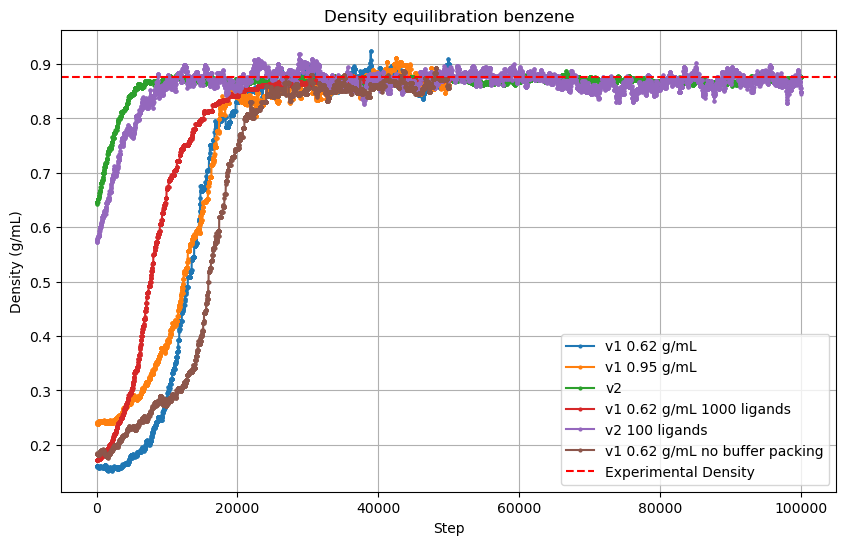

In [10]:
file_paths = [f'{path_prefix}{name}_baseline_d062.dat', f'{path_prefix}{name}_baseline_d095.dat', f'{path_prefix}{name}_full_equil.dat_0',f'{path_prefix}{name}_baseline_d062_1000.dat',f'{path_prefix}{name}_full_equil_n100.dat_0',f'{path_prefix}{name}_baseline_d062_no_buffer_packing.dat']
labels = ['v1 0.62 g/mL', 'v1 0.95 g/mL', 'v2','v1 0.62 g/mL 1000 ligands','v2 100 ligands','v1 0.62 g/mL no buffer packing']
plot_multiple_steps_vs_density(file_paths, labels,0.876,name=name)

In [15]:
from openmoltools import packmol
num_lig = 100
density = 0.62 
box_scaleup_factor = 1.5
box_buffer = 2.0
box_size = packmol.approximate_volume_by_density(
                [smiles], [num_lig], density=density, 		box_scaleup_factor=box_scaleup_factor, box_buffer=box_buffer)
box_size


##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################


ImportError: The code at packmol.py:275 requires the openeye.oechem package

In [17]:
box_size = approximate_volume_by_density([smiles], [num_lig], density=density, box_scaleup_factor=box_scaleup_factor, box_buffer=box_buffer)
box_size

43.33202539516014

In [18]:
box_scaleup_factor = 1.0
box_buffer = 0.0
box_size = approximate_volume_by_density([smiles], [num_lig], density=density, box_scaleup_factor=box_scaleup_factor, box_buffer=box_buffer)
box_size

27.554683596773422

In [ ]:
packmol_out = packmol.pack_box([ligand_mdtraj], [num_lig], box_size=box_size)

In [19]:
import openmm
schema_id = 'adb70b0f9c8b43a9a9373ada67a25377'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)

In [21]:
#get the box size of parmed_obj
from openmm import unit
box_size = parmed_obj.box_vectors[0][0] * parmed_obj.box_vectors[1][1] * parmed_obj.box_vectors[2][2]
box_size

Quantity(value=22643.569846170998, unit=angstrom**3)

In [22]:
parmed_obj.get_box()

array([[28.291, 28.291, 28.291, 90.   , 90.   , 90.   ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


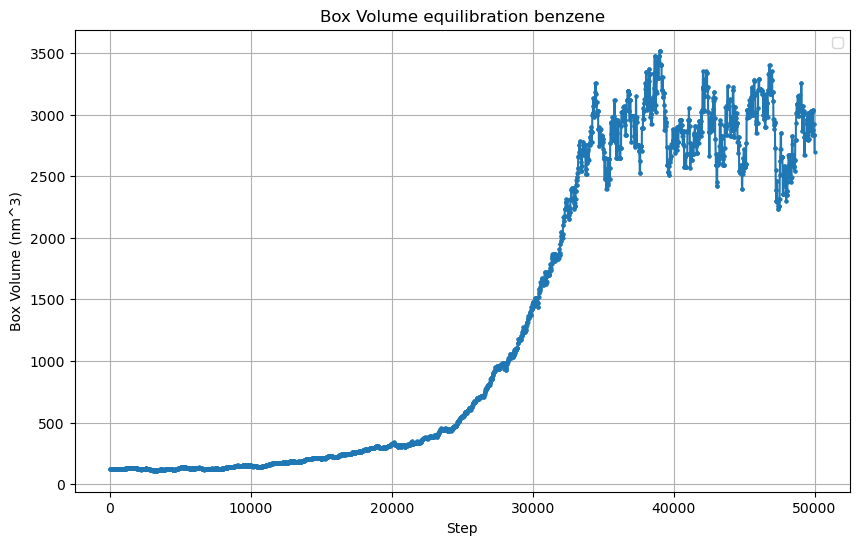

In [24]:
path_prefix = '/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_'
name = "benzene"
import matplotlib.pyplot as plt 
def plot_multiple_steps_vs_density(file_path, experimental_density = None,name=None):
    plt.figure(figsize=(10, 6))
    df = pd.read_csv(file_path)

    # Plot Step against Density with a unique color and label
    plt.plot(df['#"Step"'], df['Box Volume (nm^3)'], marker='o', linestyle='-',markersize=2)

    # Add labels, title, grid, and legend
    if experimental_density:
        plt.axhline(y=experimental_density, color='r', linestyle='--', label='Experimental Density')
    plt.xlabel('Step')
    plt.ylabel('Box Volume (nm^3)')
    if name:
        plt.title(f'Box Volume equilibration {name}')
    plt.grid(True)
    plt.legend()
    plt.show()
file_path = '/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_chloroform_baseline_d062.dat'
plot_multiple_steps_vs_density(file_path,name=name)